In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from keras.regularizers import l2
#warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Using TensorFlow backend.


In [3]:
global_epoch_number = 30

## Reading data

In [4]:
# reading data
c2g_data = pd.read_csv('data/interpol/c2g_interpol_demand.csv', index_col=0)

In [5]:
c2g_data.columns

Index(['tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday', 'Thursday

In [6]:
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)

In [7]:
unic2g_data = pd.DataFrame(c2g_data[["travels", "interpolate"]])

In [8]:
c2g_data.index = pd.to_datetime(c2g_data.index)

c2g_data = c2g_data.loc["2016-12-13 15:00:00":"2017-02-25 17:00:00"]
unic2g_data = unic2g_data.loc["2016-12-13 15:00:00":"2017-02-25 17:00:00"]


In [9]:
c2g_data.columns

Index(['tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday', 'Thursday

## LSTM Data Preparation

In [10]:
def sup_learning_formatter(data, past_lags, future_steps, train_split, all_parameters_predicted, future_steps_skipped):
    X = []
    y = []
    is_y_real = []
    
    norm_data  = data.drop(columns="interpolate").values
    
    if(all_parameters_predicted):
        for n in range(len(data) - past_lags - future_steps):
            X.append(norm_data[n : n + past_lags])
            y.append(norm_data[n + past_lags : n + past_lags + 1])
            is_y_real.append(data["interpolate"].values[n + past_lags : n + past_lags + 1]) 
        return np.array(X), np.squeeze(np.array(y)), np.array(is_y_real)
    
    else:
        for n in range(len(data) - past_lags - future_steps - future_steps_skipped):
            X.append(norm_data[n : n + past_lags])
            y.append(data.travels.values[n + past_lags + future_steps_skipped : n + past_lags + future_steps + future_steps_skipped])
            is_y_real.append(data["interpolate"].values[n + past_lags + future_steps_skipped: n + past_lags + future_steps + future_steps_skipped])
            
        return np.array(X), np.array(y), np.array(is_y_real)

In [11]:
def train_val_test_splitter(data, splits):
    locs = [int(len(data)*n) for n in splits]
    return data[:locs[0]], data[locs[0]:locs[1]], data[locs[1]:], data[0].shape

In [12]:
def eval_model(y, y_hat, is_y_real=[], are_all_real=True):
    
    if not are_all_real:
        filtered_y = [[n for n, real in zip(case, real_list) if real != 1] for case, real_list in zip(y, is_y_real)]
        filtered_y_hat = [[n for n, real in zip(case, real_list) if real != 1] for case, real_list in zip(y_hat, is_y_real)]

        filtered_y = [n for n in filtered_y if n]
        filtered_y_hat = [n for n in filtered_y_hat if n]
        
    else:
        filtered_y = y
        filtered_y_hat = y_hat
    
    n = 0
    for item in filtered_y:
        n += len(item)
    
    evaluation = {}
    evaluation["RMSE"] = np.sqrt(mean_squared_error(filtered_y, filtered_y_hat))
    evaluation["MAE"] = mean_absolute_error(filtered_y, filtered_y_hat)
    evaluation["R2"] = r2_score(filtered_y, filtered_y_hat)

    return evaluation

In [13]:
def run_lstm(data, past_lags, future_steps, splits, node_number, epochs=10, batch_size=64, loss='mae', layer_count=3,
             dropout=0.7, all_parameters_predicted=False, future_steps_skipped=0):
    
    X, y, is_y_real = sup_learning_formatter(data, past_lags, future_steps, splits[0], all_parameters_predicted, future_steps_skipped)
    X_train, X_val, X_test, X_shape = train_val_test_splitter(X, splits)
    y_train, y_val, y_test, y_shape = train_val_test_splitter(y, splits)
    is_y_real_train, is_y_real_val, is_y_real_test, is_y_real_shape = train_val_test_splitter(is_y_real, splits)

    print(X.shape)
    print(X_shape)
    print(y.shape)
    print(y_shape)
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().shuffle(batch_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val = val.batch(batch_size).repeat()

    model = tf.keras.models.Sequential()

    if(layer_count == 1):
        model.add(tf.keras.layers.LSTM(node_number,
                                    input_shape=X_shape), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))
        model.add(tf.keras.layers.Dropout(dropout))
    else:
        model.add(tf.keras.layers.LSTM(node_number, return_sequences=True,
                                    input_shape=X_shape))
        model.add(tf.keras.layers.Dropout(dropout))

        for _ in range(layer_count - 2):
            model.add(tf.keras.layers.LSTM(node_number, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

        model.add(tf.keras.layers.LSTM(node_number, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        
    model.add(tf.keras.layers.Dense(y_shape[0]))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss=loss)
    
    for x, y in val.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train, epochs=epochs, steps_per_epoch=50,
                        validation_data=val, validation_steps=50
                        )

    y_hat_val = model.predict(X_val)
    print(y_hat_val[0])
    evaluation = eval_model(y_val, y_hat_val, is_y_real_val)

    return model, history, (X_test, y_test), evaluation

In [14]:
def persistance_model(X, timesteps):
    y_hat = []
    for x in X:
        y_hat.append(np.array([x[-1][0] for _ in range(timesteps)]))
        
    return np.array(y_hat)

# Plot Generation

In [15]:
def performance_representation_plot(hour_skip, title, y_hat, y, title_in_plot=True, print_plot=True, upper_border=True, legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    
    
    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    data_predictions_array = np.array(data_predictions_array)
    data_truth_array = np.array(data_truth_array)
    
    fig = plt.figure(figsize=(20,10))
    plt.xlabel("Horas", fontdict={"fontsize":axis_label_size})
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.title(title + " (Hours Skiped = " + str(hour_skip) + ")") if title_in_plot else print(title + " (Hours Skiped = " + str(hour_skip) + ")")
    plt.ylabel("Viagens requisitadas por hora", fontdict={"fontsize":axis_label_size})
    plt.plot(data_truth_array, marker="o", label="Valores Reais")
    plt.plot(data_predictions_array, marker="D", label="Valores Previstos")
    if(not upper_border):
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(fontsize=legend_font_size)
    plt.show() if print_plot else print()

In [16]:
def save_performance_to_txt(name, y_hat, y, evaluation, hour_skip=12):

    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    
    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    
    data_array = np.array([data_predictions_array, data_truth_array])
    np.savetxt(f'results/LSTM_{name}_Predictions_by{str(hour_skip) + "Hrs"}.txt', data_array, delimiter=",")

    json_eval = json.dumps(evaluation, indent = 4) 
    with open(f'results/LSTM_{name}_Results.json', "w") as outfile: 
        outfile.write(json_eval)

# Training Models

In [17]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction[0]), 'rX-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [18]:
def plot_train_history(history, title, save_file=False):
    history = pd.DataFrame(history.history)

    history.plot(figsize=(8, 5))
    plt.grid(True)
    plt.savefig("plots\\" + title.replace(" ", "_") + ".png", bbox_inches='tight') if save_file else print()
    plt.show()

### Single Variable

In [18]:
print('Car2Go Model')
unic2g_model, unic2g_hist, unic2g_test, unic2g_eval = run_lstm(unic2g_data, 24, 12, (0.6, 0.8), 160,
                                                               epochs=global_epoch_number, dropout=0.3, layer_count = 3)

Car2Go Model
(1743, 24, 1)
(24, 1)
(1743, 12)
(12,)
(64, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 12s 231ms/step - loss: 244.5461 - val_loss: 72.3387
Epoch 2/30
50/50 [==============================] - 7s 139ms/step - loss: 80.7409 - val_loss: 70.4032
Epoch 3/30
50/50 [==============================] - 7s 134ms/step - loss: 77.4206 - val_loss: 76.8338
Epoch 4/30
50/50 [==============================] - 7s 137ms/step - loss: 66.8245 - val_loss: 50.7072
Epoch 5/30
50/50 [==============================] - 7s 131ms/step - loss: 60.2795 - val_loss: 52.3284
Epoch 6/30
50/50 [==============================] - 7s 136ms/step - loss: 50.6029 - val_loss: 59.5728
Epoch 7/30
50/50 [==============================] - 7s 139ms/step - loss: 47.9797 - val_loss: 42.4219
Epoch 8/30
50/50 [==============================] - 7s 138ms/step - loss: 44.4159 - val_loss: 38.0950
Epoch 9/30
50/50 [==============================] - 7s 131ms/step - loss: 42.65

In [19]:
unic2g_model.save(r'models/unic2g_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/unic2g_model\assets


In [20]:
print(unic2g_eval)
print(eval_model(unic2g_test[1], persistance_model(unic2g_test[0], 12)))

{'RMSE': 39.23588274536187, 'MAE': 28.118540761150854, 'R2': 0.7970264455048933}
{'RMSE': 143.9325154601481, 'MAE': 117.16021967526267, 'R2': -0.9867087854276555}


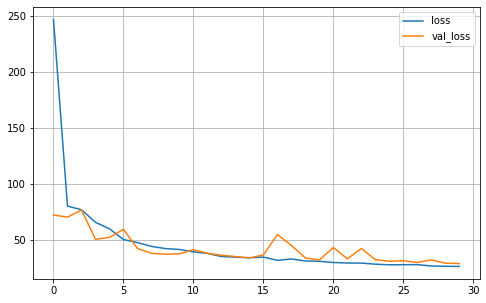

In [21]:
plot_train_history(unic2g_hist,
                   'Training and validation loss')

In [22]:
save_performance_to_txt("Car2Go_Single_Variable",
                         unic2g_model.predict(unic2g_test[0]),
                         unic2g_test[1], unic2g_eval)

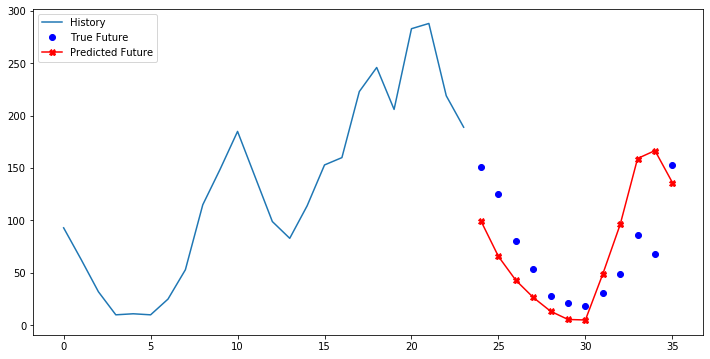

In [23]:
multi_step_plot(unic2g_test[0][10], unic2g_test[1][10], unic2g_model.predict(np.array([unic2g_test[0][10]])))

Car2Go Performance Univariável (Hours Skiped = 12)


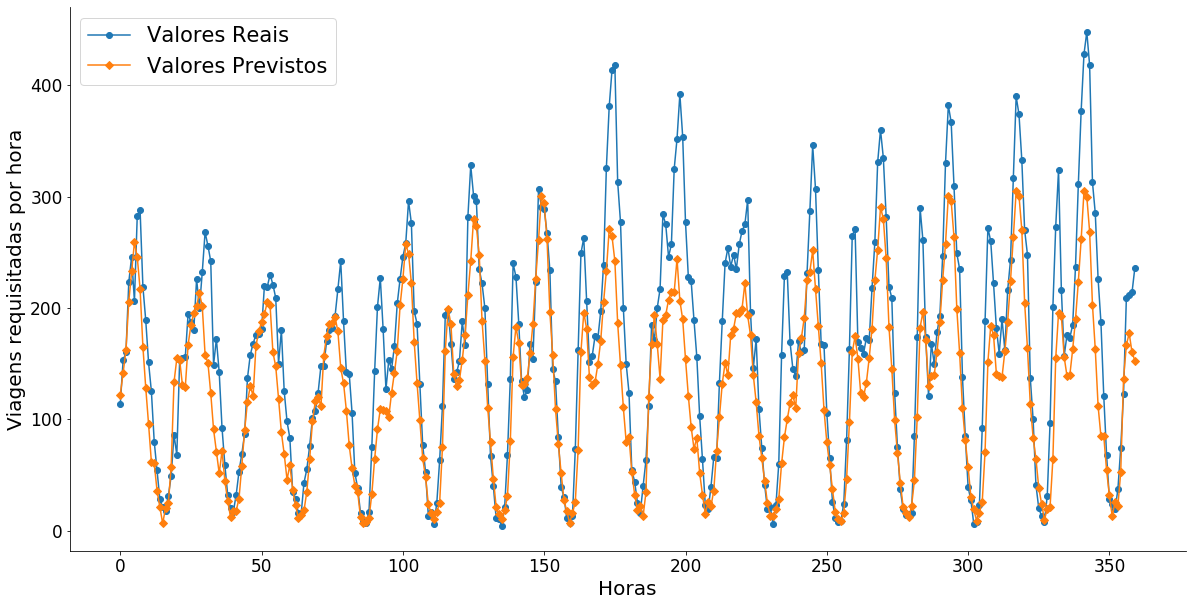

In [24]:
performance_representation_plot(12, 
                                "Car2Go Performance Univariável",
                                unic2g_model.predict(unic2g_test[0]),
                                unic2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

In [26]:
univar_array = np.array([unic2g_model.predict(unic2g_test[0]), unic2g_test[1]])
np.save(f'results/Magazine Results/LSTM_Univariable_12Hrs_Predictions.npy', univar_array)

json_eval = json.dumps(eval_model(unic2g_model.predict(unic2g_test[0]), unic2g_test[1]), indent = 4) 
with open(f'results/Magazine Results/LSTM_Univariable_12Hrs_Results.json', "w") as outfile: 
    outfile.write(json_eval)
    

### Multi Variable

In [27]:
print('Car2Go Model')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(c2g_data, 24, 12, (0.6, 0.8), 220,
                                                   epochs=global_epoch_number, dropout=0.3, layer_count = 2)

Car2Go Model
(1743, 24, 51)
(24, 51)
(1743, 12)
(12,)
(64, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 10s 210ms/step - loss: 150.5422 - val_loss: 67.4273
Epoch 2/30
50/50 [==============================] - 7s 132ms/step - loss: 79.3346 - val_loss: 50.4719
Epoch 3/30
50/50 [==============================] - 7s 133ms/step - loss: 63.5364 - val_loss: 46.4769
Epoch 4/30
50/50 [==============================] - 7s 140ms/step - loss: 52.0522 - val_loss: 57.0467
Epoch 5/30
50/50 [==============================] - 7s 134ms/step - loss: 46.5105 - val_loss: 61.3272
Epoch 6/30
50/50 [==============================] - 7s 137ms/step - loss: 44.1866 - val_loss: 59.2666
Epoch 7/30
50/50 [==============================] - 7s 132ms/step - loss: 39.7222 - val_loss: 36.7035
Epoch 8/30
50/50 [==============================] - 7s 138ms/step - loss: 38.0908 - val_loss: 36.2857
Epoch 9/30
50/50 [==============================] - 7s 132ms/step - loss: 36.

In [28]:
c2g_model.save(r'models/c2g_model')

INFO:tensorflow:Assets written to: models/c2g_model\assets


In [29]:
print(c2g_eval)
print(eval_model(c2g_test[1], persistance_model(c2g_test[0], 12)))

{'RMSE': 34.960912382996405, 'MAE': 24.956074543656655, 'R2': 0.8388324971782041}
{'RMSE': 188.38942310369976, 'MAE': 158.55945558739256, 'R2': -2.4121630093917843}


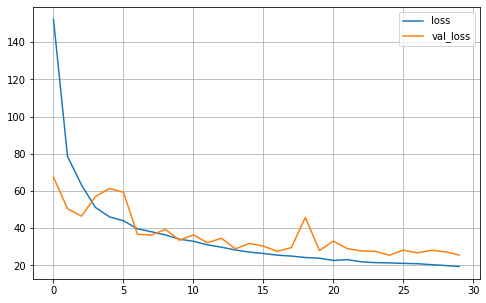

In [30]:
plot_train_history(c2g_hist, 'Training and validation loss')

In [31]:
save_performance_to_txt("Car2Go_Multivariable",
                         c2g_model.predict(c2g_test[0]),
                         c2g_test[1], c2g_eval)

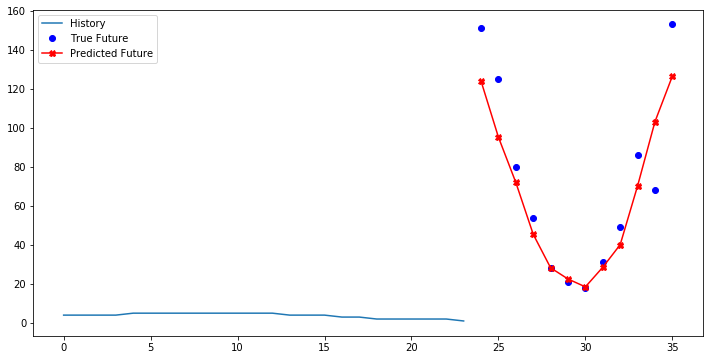

In [32]:
multi_step_plot(c2g_test[0][10], c2g_test[1][10], c2g_model.predict(np.array([c2g_test[0][10]])))

Car2Go Performance Multivariavel (Hours Skiped = 12)


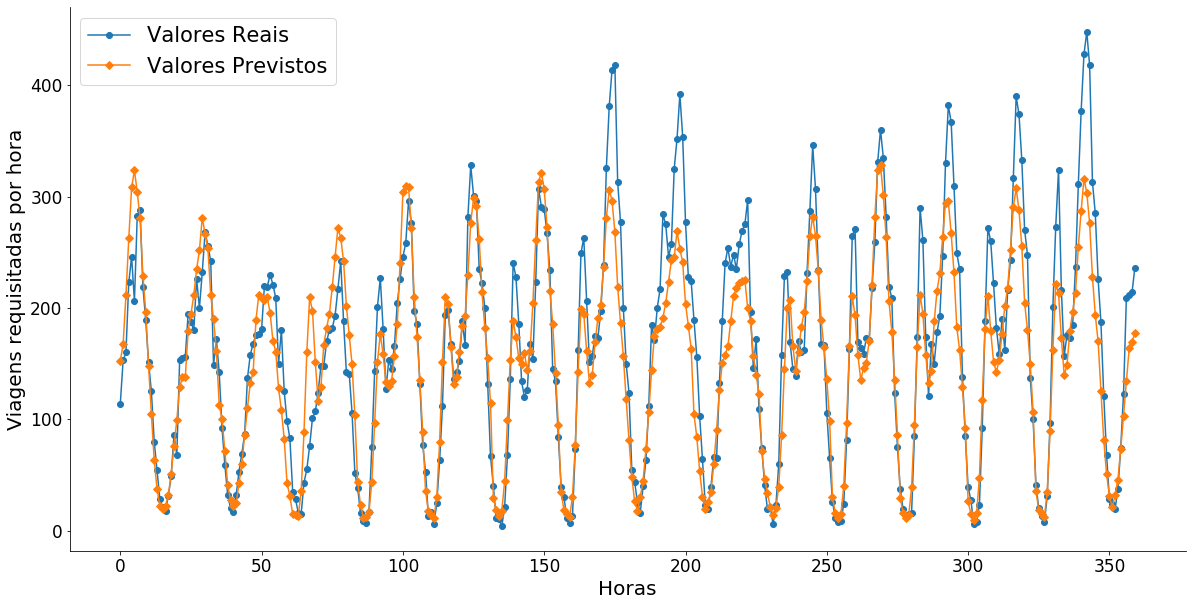

In [33]:
performance_representation_plot(12, 
                                "Car2Go Performance Multivariavel",
                                c2g_model.predict(c2g_test[0]),
                                c2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

In [34]:
multivar_array = np.array([c2g_model.predict(c2g_test[0]), c2g_test[1]])
np.save(f'results/Magazine Results/LSTM_Multivariable_12Hrs_Predictions.npy', multivar_array)

json_eval = json.dumps(eval_model(c2g_model.predict(c2g_test[0]), c2g_test[1]), indent = 4) 
with open(f'results/Magazine Results/LSTM_Multivariable_12Hrs_Results.json', "w") as outfile: 
    outfile.write(json_eval)
    

### Single-Step All Parameter prediction

In [35]:
print('Car2Go Single-Step Model')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(c2g_data, 24, 1, (0.6, 0.8), 160,
                                                   epochs=global_epoch_number, dropout=0.7,
                                                   layer_count = 2, all_parameters_predicted=True)

Car2Go Single-Step Model
(1754, 24, 51)
(24, 51)
(1754, 51)
(51,)
(64, 51)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 7s 143ms/step - loss: 6.2305 - val_loss: 5.0234
Epoch 2/30
50/50 [==============================] - 4s 82ms/step - loss: 4.5405 - val_loss: 4.2206
Epoch 3/30
50/50 [==============================] - 4s 83ms/step - loss: 4.1460 - val_loss: 4.2832
Epoch 4/30
50/50 [==============================] - 4s 81ms/step - loss: 4.2713 - val_loss: 4.1509
Epoch 5/30
50/50 [==============================] - 4s 80ms/step - loss: 4.1081 - val_loss: 4.0914
Epoch 6/30
50/50 [==============================] - 4s 82ms/step - loss: 4.1977 - val_loss: 4.0662
Epoch 7/30
50/50 [==============================] - 4s 81ms/step - loss: 3.9135 - val_loss: 3.9286
Epoch 8/30
50/50 [==============================] - 4s 79ms/step - loss: 3.8093 - val_loss: 3.6603
Epoch 9/30
50/50 [==============================] - 4s 78ms/step - loss: 3.5784 - val_loss

In [36]:
c2g_model.save(r'models/ssc2g_model')

INFO:tensorflow:Assets written to: models/ssc2g_model\assets


In [37]:
print(c2g_eval)
print(c2g_test[1][:,-2].reshape(-1, 1).shape)
print(c2g_test[1].shape)
print(eval_model(c2g_test[1][:,-2].reshape(-1, 1), persistance_model(c2g_test[0], 1)))
c2g_test[0].shape

{'RMSE': 5.936353516538431, 'MAE': 0.8610762176128323, 'R2': -0.7153153417237581}
(351, 1)
(351, 51)
{'RMSE': 4.518717010258932, 'MAE': 3.866096866096866, 'R2': -171.96596534653457}


(351, 24, 51)

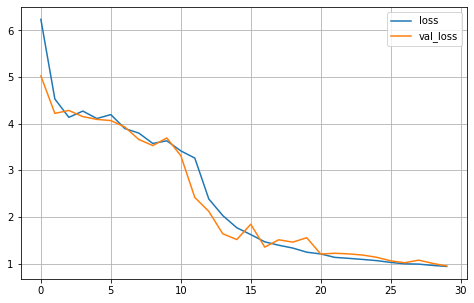

In [38]:
plot_train_history(c2g_hist, 'Training and validation loss')

Car2Go Performance Single Step (Hours Skiped = 1)


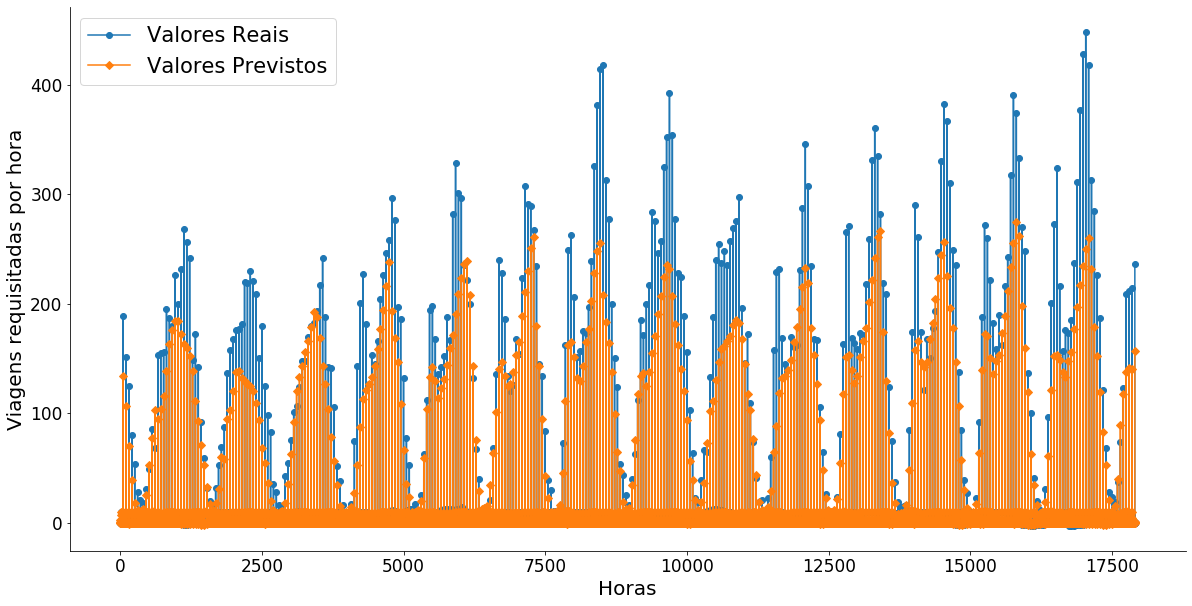

In [39]:
performance_representation_plot(1, 
                                "Car2Go Performance Single Step",
                                c2g_model.predict(c2g_test[0]),
                                c2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

In [40]:
def splitter(data, splits):
    locs = [int(len(data)*n) for n in splits]
    return data[:locs[0]], data[locs[0]:locs[1]], data[locs[1]:]

In [41]:
c2g_test_raw = splitter(c2g_data, [0.6, 0.8])[-1]

In [42]:
def supervised_learning_generator_LSTM(original_data, past_lags, future_steps):
    X = []
    y = []
    
    data = original_data.drop(columns=["interpolate"])
    
    for n in range(len(data) - past_lags - future_steps):
        X.append(data.values[n:n+past_lags,:])
        y.append(data.travels.iloc[n+past_lags:n+past_lags+future_steps])
    return np.array(X), np.array(y)

In [43]:
X, y = supervised_learning_generator_LSTM(c2g_test_raw, 24, 168)
print(X.shape, y.shape)

(164, 24, 51) (164, 168)


In [44]:
def predict_n_lstm(data, model, timesteps):
    current_iter_data = data.copy()
    results = []
    for n in range(timesteps):
        new_iteration = model.predict(current_iter_data)
        results.append(new_iteration[:,-2])
        current_iter_data[:,:-1,:] = current_iter_data[:,1:,:]
        current_iter_data[:,-1,:] = new_iteration
    return np.array(results).T

In [45]:
results = predict_n_lstm(X, c2g_model, 168)
results.shape

(164, 168)

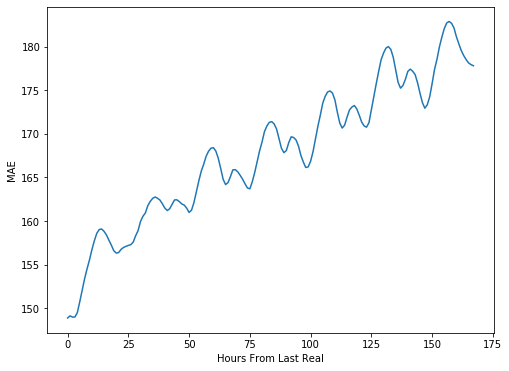

In [46]:
# Now I will get the MAE per lag
plt.plot(mean_absolute_error(y, results, multioutput="raw_values"))
plt.xlabel("Hours From Last Real")
plt.ylabel("MAE")
plt.show()

In [47]:
sslstm_array = np.array([results, y])
np.save(f'results/Magazine Results/LSTM_Multivariable_SS_Week_Predictions.npy', sslstm_array)

json_eval = json.dumps(eval_model(y, results), indent = 4) 
with open(f'results/Magazine Results/LSTM_Multivariable_SS_Results.json', "w") as outfile: 
    outfile.write(json_eval)

In [53]:
results.shape

(164, 168)

### Direct Prediction One Week From Now

In [56]:
print('Direct Prediction One Week From Now')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(c2g_data, 24, 12, (0.6, 0.8), 140,
                                                   epochs=global_epoch_number, dropout=0.5,
                                                   layer_count = 6, future_steps_skipped = 156)

Direct Prediction One Week From Now
(1587, 24, 51)
(24, 51)
(1587, 12)
(12,)
(64, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 40s 791ms/step - loss: 192.7723 - val_loss: 91.7186
Epoch 2/30
50/50 [==============================] - 13s 268ms/step - loss: 96.3628 - val_loss: 88.6791
Epoch 3/30
50/50 [==============================] - 14s 277ms/step - loss: 104.0176 - val_loss: 127.7602
Epoch 4/30
50/50 [==============================] - 13s 269ms/step - loss: 106.9477 - val_loss: 138.2950
Epoch 5/30
50/50 [==============================] - 13s 259ms/step - loss: 179.7213 - val_loss: 137.5360
Epoch 6/30
50/50 [==============================] - 13s 256ms/step - loss: 190.2337 - val_loss: 131.5891
Epoch 7/30
50/50 [==============================] - 14s 278ms/step - loss: 133.1510 - val_loss: 134.2912
Epoch 8/30
50/50 [==============================] - 14s 274ms/step - loss: 132.5639 - val_loss: 132.3946
Epoch 9/30
50/50 [=================

In [57]:
print(c2g_eval)
print(eval_model(c2g_test[1], persistance_model(c2g_test[0], 12)))

{'RMSE': 93.44611538296007, 'MAE': 71.80052526951714, 'R2': -0.3126624943494071}
{'RMSE': 191.68654395151339, 'MAE': 161.28301886792448, 'R2': -2.4183845909241355}


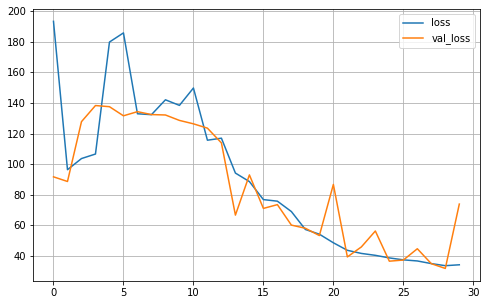

In [58]:
plot_train_history(c2g_hist, 'Training and validation loss')

In [59]:
direct_one_week_array = np.array([c2g_model.predict(c2g_test[0]), c2g_test[1]])
np.save(f'results/Magazine Results/LSTM_Multivariable_Direct_One_Week_Predictions.npy', multivar_array)

json_eval = json.dumps(eval_model(c2g_model.predict(c2g_test[0]), c2g_test[1]), indent = 4) 
with open(f'results/Magazine Results/LSTM_Multivariable_Direct_One_Week_Results.json', "w") as outfile: 
    outfile.write(json_eval)
    

### Single-Step One Parameter prediction

In [19]:
print('Car2Go Single-Step Model')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(unic2g_data, 24, 1, (0.6, 0.8), 160,
                                                   epochs=global_epoch_number, dropout=0.7,
                                                   layer_count = 2)

Car2Go Single-Step Model
(1754, 24, 1)
(24, 1)
(1754, 1)
(1,)
(64, 1)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 8s 165ms/step - loss: 157.3961 - val_loss: 82.0732
Epoch 2/30
50/50 [==============================] - 5s 102ms/step - loss: 76.4017 - val_loss: 99.8006
Epoch 3/30
50/50 [==============================] - 5s 98ms/step - loss: 57.6784 - val_loss: 49.1945
Epoch 4/30
50/50 [==============================] - 4s 87ms/step - loss: 48.2774 - val_loss: 44.7498
Epoch 5/30
50/50 [==============================] - 5s 93ms/step - loss: 43.2277 - val_loss: 39.9198
Epoch 6/30
50/50 [==============================] - 4s 83ms/step - loss: 38.4777 - val_loss: 35.6511
Epoch 7/30
50/50 [==============================] - 5s 91ms/step - loss: 37.2428 - val_loss: 41.3327
Epoch 8/30
50/50 [==============================] - 4s 84ms/step - loss: 35.1059 - val_loss: 33.7781
Epoch 9/30
50/50 [==============================] - 5s 92ms/step - loss: 32.4

In [21]:
c2g_model.save(r'models/ssunic2g_model')

INFO:tensorflow:Assets written to: models/ssunic2g_model\assets


In [24]:
print(c2g_eval)
print(c2g_test[1].reshape(-1, 1).shape)
print(c2g_test[1].shape)
print(eval_model(c2g_test[1][:].reshape(-1, 1), persistance_model(c2g_test[0], 1)))
c2g_test[0].shape

{'RMSE': 26.845648169462407, 'MAE': 19.04862356865168, 'R2': 0.9052835902626788}
(351, 1)
(351, 1)
{'RMSE': 44.372131342612334, 'MAE': 35.00569800569801, 'R2': 0.8102097174129081}


(351, 24, 1)

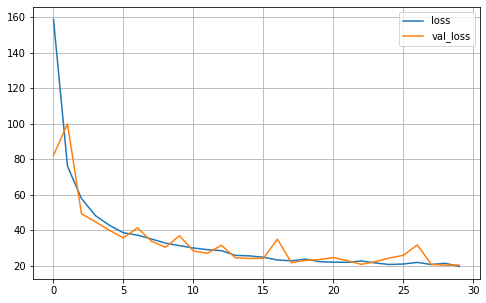

In [25]:
plot_train_history(c2g_hist, 'Training and validation loss')

Car2Go Performance Single Step (Hours Skiped = 1)


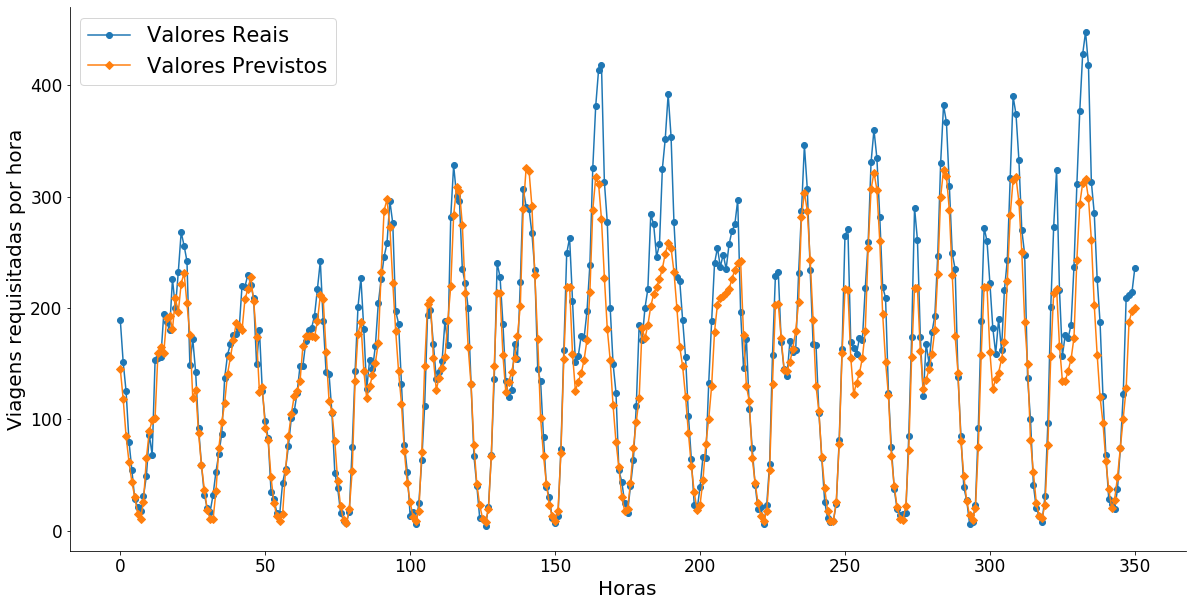

In [26]:
performance_representation_plot(1, 
                                "Car2Go Performance Single Step",
                                c2g_model.predict(c2g_test[0]),
                                c2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

In [27]:
def splitter(data, splits):
    locs = [int(len(data)*n) for n in splits]
    return data[:locs[0]], data[locs[0]:locs[1]], data[locs[1]:]

In [38]:
c2g_test_raw = splitter(unic2g_data, [0.6, 0.8])[-1]

In [47]:
def supervised_learning_generator_UniLSTM(original_data, past_lags, future_steps):
    X = []
    y = []
    
    data = original_data.drop(columns=["interpolate"])
    
    for n in range(len(data) - past_lags - future_steps):
        X.append(data.values[n:n+past_lags,:])
        y.append(data.travels.iloc[n+past_lags:n+past_lags+future_steps])
    return np.array(X), np.array(y)

In [48]:
X, y = supervised_learning_generator_UniLSTM(c2g_test_raw, 24, 168)
print(X.shape, y.shape)

(164, 24, 1) (164, 168)


In [64]:
def predict_n_unilstm(data, model, timesteps):
    current_iter_data = data.copy()
    results = []
    for n in range(timesteps):
        new_iteration = model.predict(current_iter_data)
        results.append(new_iteration)
        current_iter_data[:,:-1,:] = current_iter_data[:,1:,:]
        current_iter_data[:,-1,:] = new_iteration
    return np.squeeze(np.array(results).T)

In [65]:
results = predict_n_unilstm(X, c2g_model, 168)
results.shape

(164, 168)

In [66]:
y.shape

(164, 168)

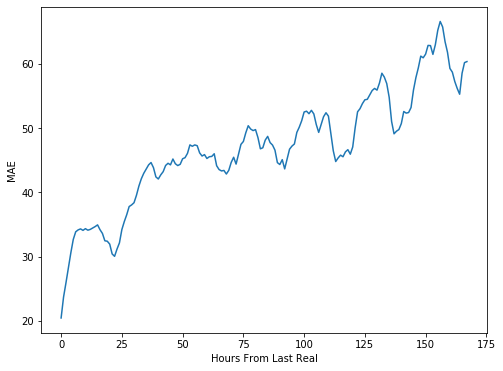

In [67]:
# Now I will get the MAE per lag
plt.plot(mean_absolute_error(y, results, multioutput="raw_values"))
plt.xlabel("Hours From Last Real")
plt.ylabel("MAE")
plt.show()

In [68]:
sslstm_array = np.array([results, y])
np.save(f'results/Magazine Results/LSTM_Univariable_SS_Week_Predictions.npy', sslstm_array)

json_eval = json.dumps(eval_model(y, results), indent = 4) 
with open(f'results/Magazine Results/LSTM_Univariable_SS_Results.json', "w") as outfile: 
    outfile.write(json_eval)